Прогнозирование временных рядов с помощью RNN

Выполнить прогноз продаж по датасету https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

Критерии оценки: Ошибка RMSE

RMSE ~138 (+-46) 

In [1]:
from numpy.random import seed
seed(42) # фиксируем сид

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import set_random_seed
set_random_seed(42) # фиксируем сид
import keras 

Using TensorFlow backend.


Загрузим датасет

In [2]:
df = pd.read_csv('shampoo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
Month    36 non-null object
Sales    36 non-null float64
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


In [3]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


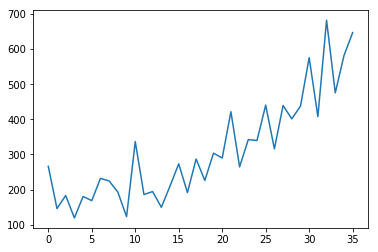

In [4]:
df['Sales'].plot()

In [5]:
data = np.array(df['Sales'].values)
# tr_data = data.copy()
# tr_data -= data.mean()
# tr_data /= data.std()
data.min(), data.max(), data.shape

(119.3, 682.0, (36,))

In [6]:
data.size

36

In [7]:
def get_xy(data,month_pred = 3):
    """
    функция принимает временной ряд и по какому числу месяцев делать предсказание.
    Возвращает данные за предыдущие month_pred в качестве х и следущий месяц в качестве у
    """
    X = []
    y = []

    for i in range(data.size-month_pred):
        X_el = np.zeros(month_pred)
        for j in range(month_pred):
            X_el[j]=data[i+j]
        X.append(X_el)
        y.append(data[i+month_pred])

    X = np.array(X)
    y = np.array(y)
    return X,y

month_pred = 3
X, y =get_xy(data,month_pred)
X.shape, y.shape

((33, 3), (33,))

Разделим выборки

In [8]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X[:21,:] 
X_test = X[22:,:]
y_train = y[:21]
y_test = y[22:]

X_train.shape, X_test.shape

((21, 3), (11, 3))

В качестве базовой модели возьмем значение следущего месяца за текущий

In [9]:
def rmse(y_pred,y_true):
    return np.sqrt(np.mean((y_true-y_pred)**2))

rmse(X[:,-1],y)

109.29952452140887

небольшая ошибка, относительно дз RMSE ~138 (+-46) 

Попробую для интереса обычную НС

In [10]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

model = Sequential()
model.add(Dense(32, input_shape=(month_pred,), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(), loss=root_mean_squared_error)
history = model.fit(X_train, y_train,
          batch_size=10, nb_epoch=100,
          verbose=1, validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None


C:\ProgramData\Anaconda3\envs\DS 3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 14 samples, validate on 7 samples
Epoch 1/100
14/14 [==============================] - 1s 68ms/step - loss: 97.1715 - val_loss: 151.2211
Epoch 2/100
14/14 [==============================] - 0s 643us/step - loss: 102.5205 - val_loss: 145.3227
Epoch 3/100
14/14 [==============================] - 0s 500us/step - loss: 101.5389 - val_loss: 139.1244
Epoch 4/100
14/14 [==============================] - 0s 643us/step - loss: 110.4906 - val_loss: 132.6239
Epoch 5/100
14/14 [==============================] - 0s 643us/step - loss: 72.7126 - val_loss: 126.5522
Epoch 6/100
14/14 [==============================] - 0s 500us/step - loss: 94.0046 - val_loss: 120.4413
Epoch 7/100
14/14 [==============================] - 0s 572us/step - loss: 93.9459 - val_loss: 114.2216
Epoch 8/100
14/14 [==============================] - 0s 500us/step - loss: 90.0746 - val_loss: 107.9614
Epoch 9/100
14/14 [==============================] - 0s 572us/step - loss: 68.9912 - val_loss: 101.8343
Epoch 10/100
14/14 

In [11]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    строит график loss
    """
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

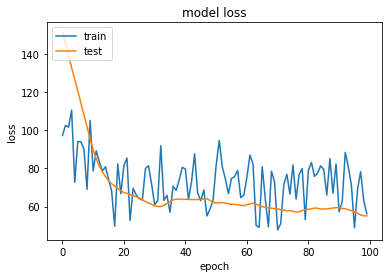

In [12]:
plot_loss(history)

In [13]:
model.evaluate(X_test, y_test, verbose=1)

11/11 [==============================] - 0s 362us/step


86.95880889892578

In [14]:
y_pred = model.predict(X_test)
list(zip(y_pred, y_test))

[(array([306.70557], dtype=float32), 440.4),
 (array([346.6344], dtype=float32), 315.9),
 (array([364.51035], dtype=float32), 439.3),
 (array([355.21582], dtype=float32), 401.3),
 (array([380.041], dtype=float32), 437.4),
 (array([396.19345], dtype=float32), 575.5),
 (array([440.1183], dtype=float32), 407.6),
 (array([473.86337], dtype=float32), 682.0),
 (array([493.77005], dtype=float32), 475.3),
 (array([539.1848], dtype=float32), 581.3),
 (array([513.5615], dtype=float32), 646.9)]

Модель не переобучается, и результаты чуть лучше базовой (Линейная регрессия?=) )

In [15]:
from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
month_pred = 4
tr_data = data.copy()

tr_data = scaler.fit_transform(tr_data.reshape(-1,1))
X, y = get_xy(tr_data,month_pred)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
size = int(X.shape[0]*0.7)
X_train = X[:size,:] 
X_test = X[size+1:,:]
y_train = y[:size]
y_test = y[size+1:]
X_train.shape, X_test.shape

((22, 4), (9, 4))

In [16]:
# перемешаем обучающую выборку, чтобы снизить переобучение у RNN
indeces = np.arange(y_train.size)
np.random.shuffle(indeces)
X_train = X_train[indeces,:]
y_train = y_train[indeces]
# y_train, indeces

(array([[0.16136485],
        [0.08743558],
        [0.18962147],
        [0.57064155],
        [0.19992891],
        [0.12813222],
        [0.13062022],
        [0.05366981],
        [0.25804159],
        [0.32752799],
        [0.11835792],
        [0.27368047],
        [0.29802737],
        [0.00639773],
        [0.18695575],
        [0.1084059 ],
        [0.13328594],
        [0.39630354],
        [0.38599609],
        [0.30318109],
        [0.39168296],
        [0.53723121]]),
 array([10,  1, 14, 21,  2, 12,  4,  9, 18, 15,  7, 11, 13,  5,  3,  0,  8,
        19,  6, 16, 20, 17]))

In [17]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(y_train.size,)
y_test = y_test.reshape(y_test.size,)
trainX.shape, y_train.shape

((22, 1, 4), (22,))

In [19]:
from keras.layers import LSTM, GRU, Flatten
from keras.optimizers import RMSprop

model = Sequential()
# model.add(LSTM(8,dropout=0.8,recurrent_dropout=0.8, return_sequences=True, input_shape=(1,month_pred)))
# model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5, return_sequences=True, input_shape=(1,month_pred)))
# model.add(LSTM(8,dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
# model.add(GRU(64,return_sequences=True,input_shape=(1,month_pred)))
model.add(GRU(128,return_sequences=True,input_shape=(None,month_pred)))
model.add(Dropout(0.8))
model.add(GRU(128,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

print(model.summary())

# model.compile(optimizer=Adam(), loss=root_mean_squared_error)
# model.compile(optimizer=Adam(), loss='mean_squared_error')
model.compile(optimizer=RMSprop(lr=0.001), loss=root_mean_squared_error)
# model.compile(optimizer=RMSprop(), loss='mean_squared_error')
history = model.fit(trainX, y_train,
          batch_size=10, nb_epoch=100,
          verbose=1, validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         51072     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 149,889
Trainable params: 149,889
Non-trainable params: 0
_________________________________________________________________
None


C:\ProgramData\Anaconda3\envs\DS 3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15 samples, validate on 7 samples
Epoch 1/100
15/15 [==============================] - 1s 70ms/step - loss: 0.1744 - val_loss: 0.2266
Epoch 2/100
15/15 [==============================] - 0s 999us/step - loss: 0.1190 - val_loss: 0.1825
Epoch 3/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0888 - val_loss: 0.1647
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1088 - val_loss: 0.1439
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0913 - val_loss: 0.1541
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0969 - val_loss: 0.1438
Epoch 7/100
15/15 [==============================] - 0s 1000us/step - loss: 0.1040 - val_loss: 0.1391
Epoch 8/100
15/15 [==============================] - 0s 1000us/step - loss: 0.1013 - val_loss: 0.1458
Epoch 9/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1048 - val_loss: 0.1485
Epoch 10/100
15/15 [==============================] - 0s 

Epoch 82/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0871 - val_loss: 0.1403
Epoch 83/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0768 - val_loss: 0.1383
Epoch 84/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0734 - val_loss: 0.1355
Epoch 85/100
15/15 [==============================] - 0s 933us/step - loss: 0.0702 - val_loss: 0.1379
Epoch 86/100
15/15 [==============================] - 0s 933us/step - loss: 0.0634 - val_loss: 0.1323
Epoch 87/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.1321
Epoch 88/100
15/15 [==============================] - 0s 933us/step - loss: 0.0748 - val_loss: 0.1314
Epoch 89/100
15/15 [==============================] - 0s 1000us/step - loss: 0.0689 - val_loss: 0.1347
Epoch 90/100
15/15 [==============================] - 0s 1000us/step - loss: 0.0709 - val_loss: 0.1335
Epoch 91/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0982 - val_l

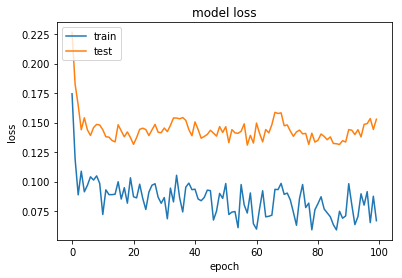

In [20]:
plot_loss(history)

In [21]:
y_pred = model.predict(testX)
y_p = scaler.inverse_transform(y_pred.reshape(-1,1))
y_t = scaler.inverse_transform(y_test.reshape(-1,1))
np.sqrt(np.mean((y_t-y_p)**2))

182.45773044540672

С LSTM очень сильно переобучается, GRU получше. Самое оптимальное - 2 скрытых слоя, в остальных случаях растет ошибка. Количество нейронов и дропаут подобраны тоже наилучшие. Изменение количества месяцев увеличивыет переобучение. Разные запуски дают RMSE 80-185, что укладывается в ДЗ. Справится с переобучением получается только за счет ухудшения модели RMSE>250. На данном датасете обычная сеть отработала лучше.